# Chapter 4. Training Models

In many situations, we need to understand the implementation of specific algorithms. Understanding the underlying logic of machine learning algorithms will help us to:
- Pick the right one for the task
- Pick a good initial set of hyper-parameters
- Pick a good training algorithm

Lastly, most of the topics discussed in this chapter will be essential for understanding neural networks.

In this chapter, we will start by looking at linear regression training from two different angles:
- Using a direct "closed-form" analytical method to get the optimal parameters for the linear model.
- Using an interative optimization method called gradient descent.

GD gradually tweaks the model parameters until it converges to the same set of parameters found by method 1. We will take a look at multiple types of gradient descent: stochastic GD, batch GD, Mini-batch GD.

Next we will look at polynomial regression, or models that can fit non-linear datasets. Then we will look at several regularization techniques that will help up reduce the overfitting typically found in polynomial models.

Finally, we will look at two popular models used for classification tasks: Logistic regression & softmax regression.

## Linear Regression

In chapter I, we looked at a simple model for *Life Satisfaction*:

$$life\_satisfaction = \theta_{0} + \theta_{1} \times GDP\_per\_capita$$

This model is just a linear function of `GDP_per_Capita` with $\theta_{0}$ and $\theta_{1}$ as parameters. A linear model makes a prediction by simply computing the weighted sum of the input features + a constant called a bias term. More generally:

$$\hat{y} = \theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} + \dots + \theta_{n}x_{n}$$

This can be written much more consicely using its vectorized form:

$$
\hat{y}=h_{\theta}(x)=\theta \cdot x \space | \space
\theta=\begin{bmatrix} \theta_{0}  \\ \theta_{1}  \\ \vdots  \\ \theta_{n} \end{bmatrix},
x=\begin{bmatrix} 1 \\ x_{1} \\ \vdots \\ x_{n} \end{bmatrix}
$$

*Note:* $\cdot$ in $\theta \cdot x$ represent the dot product & not vector multiplication.

$h_{\theta}(x)$ is the hypothesis function using parameters $\theta$.

In ML, vectors are often represented as column arrays, because $\theta$ and $x$ are both column vectors, we can write the prediction as follows:

$$\hat{y} = \theta^{T} x$$

Now, $\hat{y}$ is a single-cell matrix resulting from matrix multiplication.

In this book, we will use this notation to avoid switching between dot products and matrix multiplications.

Training a model means adjusting its parameters so it best fits the data. For us to succeed, we first need to describe what do we mean by "best fitting the data". For this reason, we pick the mean sqaured error ($MSE$) as measure of the model performance:

$$MSE(X,h_{\theta}) = \frac{1}{m} \sum_{i=1}^{m} (\theta^{T}x^{(i)} - y^{(i)})^2$$

Where $X$ is the training data set represented as $X=\{(x_{1},y_{1}), (x_{2},y_{2}), \dots, (x_{m},y_{m})\}$

### The Normal Equation

To find $\theta$ that minimizes the cost/loss function $MSE(\theta)$, there is a closed form solution. In other words, a mathematical equation that gives the result directly, and it's called the normal equation.

$$\hat{\theta}=(X^{T}X)^{-1}X^{T}y$$

$\hat{\theta}$ is the value of $\theta$ that minimizes the cost function $MSE(\theta)$.

Let's generate some linear data to test this equation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

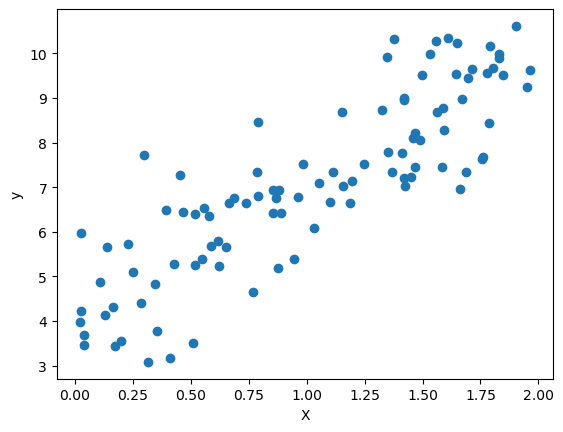

In [3]:
plt.scatter(x=X, y=y)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Now let's compute $\hat{\theta}$ using the normal equation:

In [4]:
X_b = np.c_[np.ones_like(X), X]

In [5]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.10161706],
       [2.90838898]])

The parameters that we used to generate the data (with some noise) are $\theta_{0}=4$ and $\theta_{1}=3$. The noise was responsible for not making it possible to recover the initial parameters $\theta_{0}$ & $\theta_{1}$.

Now we can make predictions using our optimal parameters:

In [6]:
X_ = np.array([[0], [2]])
X_ = np.c_[np.ones_like(X_), X_].T
X_.shape

(2, 2)

In [7]:
y_hat = np.matmul(theta_best.T, X_)

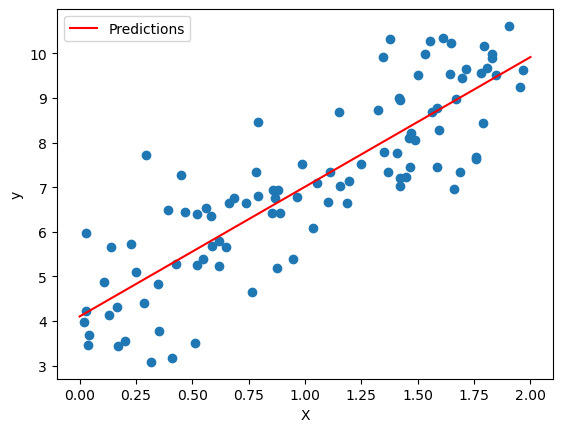

In [8]:
plt.scatter(x=X, y=y)
plt.plot([0,2], y_hat.flatten(), color='red', label='Predictions')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

Performing Linear Regression using `scikit-learn` is also simple:

In [9]:
from sklearn.linear_model import LinearRegression

In [10]:
lin_reg = LinearRegression(n_jobs=-1)

In [11]:
lin_reg.fit(X, y)

LinearRegression(n_jobs=-1)

In [12]:
lin_reg.intercept_, lin_reg.coef_

(array([4.10161706]), array([[2.90838898]]))

In [13]:
lin_reg.predict(np.array([[0],[2]]))

array([[4.10161706],
       [9.91839502]])

The `LinearRegression` class is based on `scipy.linalg.lstsq` function which we could call directly:

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)

In [15]:
theta_best_svd

array([[4.10161706],
       [2.90838898]])

The function computes $\hat{\theta}=X^{+}y$ where $X^{+}$ is the Moore-Penrose inverse, $X^{+}=(X^{T}X)^{-1}X^{T}$. 

We can compute it directly:

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[4.10161706],
       [2.90838898]])

The pseudoinverse itself is computed using a **standard matrix vectorization** technique called **Singular Value Decomposition** (SVD). SVD can decompose the training set $X$ into the matrix multiplication of 3 matrices: $U \space \Sigma \space V^{T}$. As a result, we have $X^{+}=V \Sigma^{+} U^{T}$.

To compute the matrix $\Sigma^{+}$, the algorithm takes $\Sigma$ and sets to zero all values smaller than an $\epsilon$, replaces all the non-zero values with their inverse, and finally transposes the resulting matrix.

This approach is more efficient than directly computing the normal equation and it handles edge cases nicely.

The nomral equation may not work if $X^{T}X$ is not invertible but the pseudoinverse is always defined.

### Computational Complexity

The normal equation computes the inverse of $X^{T}X$, which is an $(n+1) \times (n+1)$ matrix (where n is the number of features). The computation complexity of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^{3})$, depending on the implementation. In other words, **if you double the number of features, you will increase the computation time by x5.3 to x8.**

Both the normal equation & SVD approaches get very slow with a large number of features (~100,000). On a positive side, both are linear when it comes to the number of instances (or observations) we have in $X$.

Once we trained our model using the normal equation or SVD, predictions are exported really fast (with a linear complexity on both instances and features).

Now we will look at a completely different way of finding the optimal parameters $\theta$.

It is suitable when we have too many features or instances we can't fit in memory:

## Polynomial Regression

What if the data is more complex than a straight line? We can't use a linear model to fit non-linear data.

A simple way to do this is to **add powers of each feature as new features then train a linear model on this set of features**. This technique is called polynomial regression.

Let's look at an example. let's start by generating some nonlinear data, based on a simple quadratic equation + some noise:

In [17]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

Basically:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

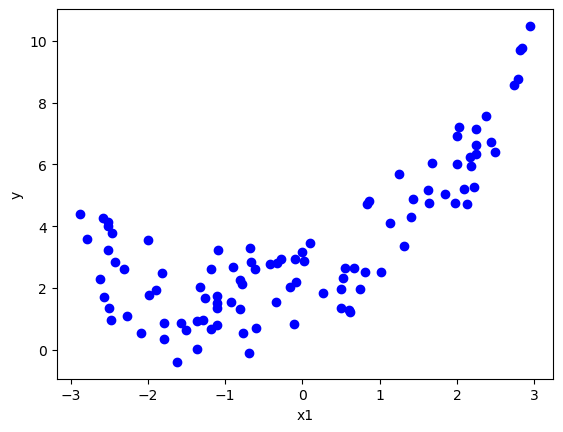

In [18]:
plt.scatter(X, y, color='blue')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

Clearly a straight line will never fit this data properly.

As a solution, let's add $x^{2}$ as a new feature to $X$, then train a simple linear model:

In [19]:
from sklearn.preprocessing import PolynomialFeatures

In [20]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)

In [21]:
X_poly = poly_features.fit_transform(X)

In [22]:
X_poly[:3]

array([[ 0.49998368,  0.24998368],
       [ 0.61559525,  0.37895751],
       [-0.0830155 ,  0.00689157]])

In [23]:
lin_reg = LinearRegression()

In [24]:
lin_reg.fit(X_poly, y)

LinearRegression()

In [25]:
lin_reg.intercept_, lin_reg.coef_

(array([1.98232397]), array([[0.985397  , 0.50566212]]))

Let's plot it:

In [26]:
X_p = np.linspace(start=-3, stop=3, num=100).reshape(-1, 1)
X__p = poly_features.transform(X_p)
y_p = lin_reg.predict(X=X__p)

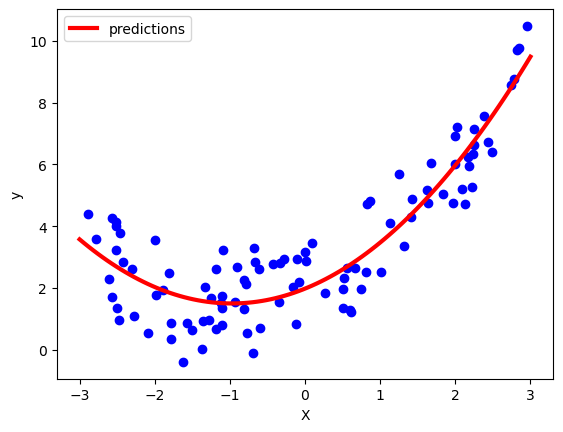

In [27]:
plt.scatter(X, y, color='blue')
plt.plot(X_p, y_p, color='red', label='predictions', linewidth=3)
plt.xlabel('X')
plt.ylabel('y')
plt.legend(loc='upper left')
plt.show()

Not bad, training results in the following hypothesis:

$$y= (0.50463537) * x^{2} + (1.07951347) * x + 2 + 0.03834072$$

Which is very close to:

$$y=\frac{1}{2}x^{2} + x + 2 + N(\mu, \sigma)$$

When we have powers of features, polynomial linear regression is capable of finding non-linear relationships. Which is something a plain linear regression model cannot do. This is made possible by the fact that `PolynomialFeatures` adds all possible combinations of features up to a certain degree.

## Learning Curve

If we fit our training data with polynomial regression, we will likely fit it much better than with just `LinearRegression`, but beware that as we augment the degree of the polynomial, we're giving it more predictive power:

<div style="text-align:center;"><img style="width: 66%;" src="static/imgs/Power_degrees.png"></div>

We notice how the 300 degree polynomial model wiggles around to get as close as possible to all of the training data points.
- Degree 1 — **Underfitting**
- Degree 2 — **Fitting**
- Degree 300 — **Overfitting**

Because we generated synthetic data using a qudratic function, we know that degree 2 is good, but in most cases, we won't know the function that generated the data!

The next logical questions is: "How to know if our model is overfitting or underfitting?". The validation dataset is to the rescue:
- If our model performs good on the training data but badly on the validation data —> Overfitting
- If our model performs badly on the training data & badly on the validation data —> Underfitting
- If our model performs good on the training data & good on the validation data —> Fitting

Another way to tell if we're overfitting/underfitting is to look at the learning curves. We should analyze the curves that show performance over the training set versus validation set with varying training set sizes. To generate the plot, we should train the same model on different training set sizes:

In [28]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [29]:
def plot_learning_curve(model, X, y):
    """Plots model training/validation's MSE over different sizes of training sets.
    
    # Arguments
        model: sklearn.*, a scikit-learn model to be trained/tested.
        X: np.ndarray, the input dataset.
        y: np.ndarray, the output dataset.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    train_errors, val_errors = list(), list()
    for m in range(1, X_train.shape[0]):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_test, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='Training Loss')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=3, label='Validation Loss')
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.ylim([0, 3])
    plt.legend(loc='upper right')
    plt.show()

Let's look at the learning curves of a plain linear regression model:

In [30]:
from sklearn.linear_model import LinearRegression

In [31]:
lin_reg = LinearRegression()

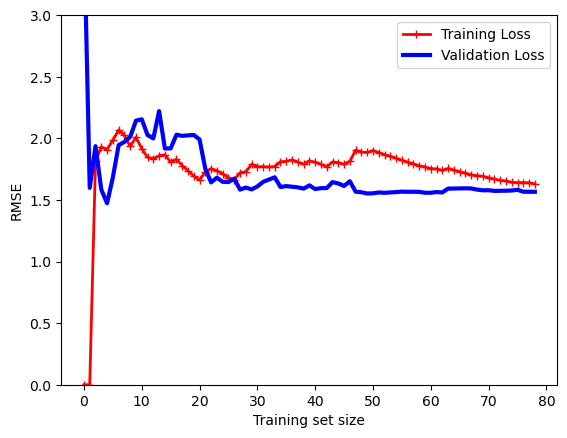

In [32]:
plot_learning_curve(lin_reg, X, y)

When there are `1` or `2` instances in the training set, the model can fit them perfectly. But when we add more training data, it becomes impossible for the model to fit all points perfectly. Both because the data is noisy and because the data isn't linear at all.

The training `RMSE` converges to a plateau and if we add more data, RMSE doesn't get effected as much. On the other hand, when the model is trained on a few instances, it's not able to generalize well hence the bad losses for `val`. 

As the model is shown more examples, it learns general patterns and the `val` error converges to the training error.

**These curves are typical for a model that is underfitting**.

If our model is underfitting the data, **adding more data points will not help**, we need to **add more features or use a more complex model**.

Let's fit and visualize the curves of a 10-degree polynomial model:

In [33]:
from sklearn.pipeline import Pipeline

In [34]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression())
])

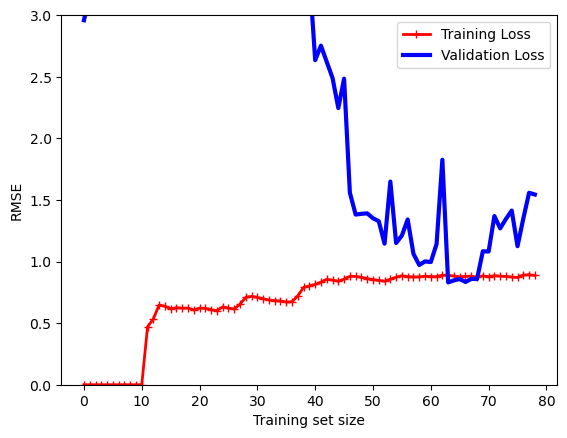

In [35]:
plot_learning_curve(polynomial_regression, X, y)

These learning curves look very similar to the previous ones, but there are some key differences:
- The error on the training data is much lower than in the previous example.
- there is a **gap** between the curves, meaning the model performs much better on the training set than on the validation set. Which is the hallmark of an overfitting model.

One solution to overfitting **is to have more training data until the validation loss reaches the training loss**.

An important theoretical result of statistics and ML is that the generalizability error can be expressed as the sum of three very different erros:

**Bias**: Has to do with wrong assumptions, like assuming the data is linear when it's actually quadratic. A high bias model is most likely to underfit the training data.

**Variance**: Has to do with a model's excessive sensitivity to the training data. A high variance model tends to overfit the training data.

Every dataset has what we call **irreducible Error** (the noisiness of the data itself). The only way to reduce this error is to fix the data. Increasing a model's complexity will typically increase its variance and decrease bias (with a less restricted model). Reducing the model's complexity will increase bias and decrease variance.

This is what we call the bias-variance trade-off.

## Regularized Linear Models

A good way to reduce overfitting is to regularize the model. 

For exmaple, a simple way to regularize a polynomial model is to reduce the number of degrees it has. For a linear model, regularization is typically achieved by constraining the model's weights range.

Let's look at 3 other methods to constrain the weights of a linear model: 

## Logistic Regression

Logistic regression is commonly used to estimate the probability that an instance belongs to a certain class.

### Estimating Probabilities

Just like linear regression, a Logistic regression model computes a weighted sum of the features + a bias term. However, instead of outputting the result directly, it computes the logistic of it.

Let the input be $X \in \Bbb{R}^{m \times n}$ and parameters $\theta \in \Bbb{R}^{n \times 1}$:

$$\hat{p}=h_{\theta}(X)=\sigma(X\theta) \space ; \sigma(t)=\frac{1}{1+e^{-t}}$$

The logistic, denoted $\sigma(.)$ is a sigmoid function, that outputs a number between 0 and 1:

In [36]:
sigma_x = np.linspace(start=-10., stop=10., num=100)

In [37]:
def sigmoid(x):
    """calculates the output of the sigmoid function.
    
    # Arguments
        x: np.ndarray, the input to the sigmoid function
    
    # Returns
        y: np.ndarray, the output from the sigmoid function
    """
    return 1/(1 + np.exp(-x))

In [38]:
sigma_y = sigmoid(sigma_x)

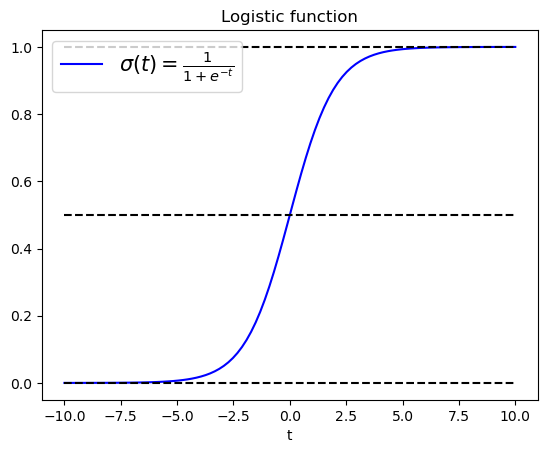

In [39]:
plt.plot(sigma_x, sigma_y, color='blue', label=r'$\sigma(t)=\frac{1}{1 + e^{-t}}$')
plt.plot([-10, 10], [1/2, 1/2], '--', color='black')
plt.plot([-10, 10], [1, 1], '--', color='black')
plt.plot([-10, 10], [0, 0], '--', color='black')
plt.xlabel('t')
plt.legend(loc='upper left', fontsize=15)
plt.title('Logistic function')
plt.show()

Once the logistic regression function has estimated the probability $\hat{p}$ that the instance belongs to the positive class, a prediction can be extracted:

$$\hat{y}=\begin{cases}1, & \text{if $\hat{p} \ge 0.5$} \\ 0, & \text{if $\hat{p} < 0.5$}\end{cases}$$

### Training and Cost Function

Now we know how a logistic regression model estimates probabilities and makes predictions. but how is it trained?

The objective of training is to set parameters $\theta$ for $h_{\theta}$ to predict high probabilities for positive instances and low probabilities for negative instances. We can capture this idea by presenting the following cost function:

$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}[y^{(i)}log(\hat{p}^{(i)}) + (1-y^{(i)})log(1-\hat{p}^{(i)})]$$
$$J(\theta)=-\frac{1}{m}\sum_{i=1}^{m}c^{(i)}(\theta) \space; c^{(i)}(\theta)=\begin{cases}log(\hat{p}^{(i)}) & if y^{(i)}=1 \\ log(1-\hat{p}^{(i)}) & if y^{(i)}=0\end{cases}$$

This function makes sense because:
- $-log(t)$ grows very large ($\to +\infty$) when $t \to 0$: a high cost for a positive instance labeled as negative.
- $-log(1-t)$ grows very large when $t \to 1$: a high cost for a negative instance labeled as positive.
- $-log(t)$ is close to $0$ when $t \to 1$: a low cost for a positive instance labeled as positive.
- $-log(1-t)$ is close to $0$ when $t \to 0$: a low cost for a negative instance labeled as negative.

The Bad News is that there is no known closed form equation to calculate $\hat{\theta}$ that minimizes $J(\theta)$. The Good News is that this cost function is Convex.

The partial derivative of $J(\theta)$ with regards to $\theta_{j}$ is:

$$\frac{\partial{J}}{\partial{\theta_{j}}}(\theta)=\frac{1}{m}\sum_{i=1}^{m}(\sigma(\theta^{T}x^{(i)})-y^{(i)})x_{j}^{(i)}$$

This equation looks very similar to the gradient of Mean Squared Error.

### Decision Boundaries

Let's use the Iris dataset to illustrate Logistic Regression. We will build a classifier to detect the **Iris virginica** types based only on the **petal width** feature:

In [40]:
from sklearn import datasets

In [41]:
iris = datasets.load_iris()

In [42]:
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [43]:
iris.data.shape

(150, 4)

In [44]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [47]:
X = iris.data[:, 3:]  # Petal Width
y = (iris.target == 2).astype(np.int_)  # 1 if iris verginica, else 0

In [48]:
X.shape, y.shape

((150, 1), (150,))

Let's train a logistic regression model:

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
log_reg = LogisticRegression(solver='liblinear')

In [51]:
log_reg.fit(X, y)

LogisticRegression(solver='liblinear')

In [52]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

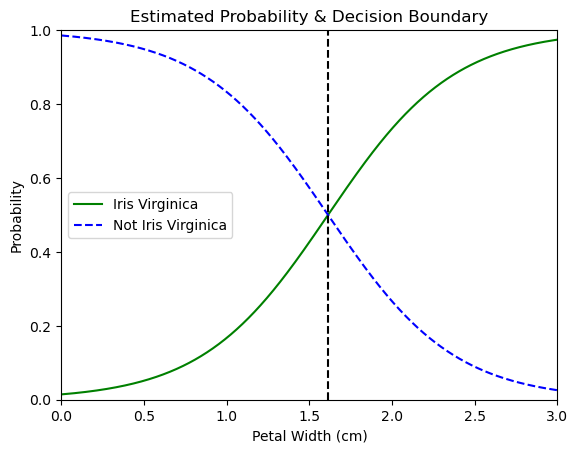

In [53]:
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris Virginica')
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris Virginica')
plt.plot([1.61, 1.61], [0, 1], '--', color='black')
plt.xlabel('Petal Width (cm)')
plt.ylabel('Probability')
plt.title('Estimated Probability & Decision Boundary')
plt.xlim((0., 3.))
plt.ylim((0., 1.))
plt.legend(loc='center left', fontsize=10)
plt.show()

The decision boundary is at about 1.6 centemeter.

The `.predict()` method doesn't care about its confidance, it just outputs a binary indicator based on conditions (ex. if: $predicted\_proba > 0.5$):

In [54]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/2d_decision_boundary.png"></div>

This figure shows the same decision boundary but for two features: `petal length` and `petal width`. The colored lines show the boundaries associated with the confidance probabilities of the trained logistic regressor.

Just like other linear regressors, we can add $l1$ and $l2$ penalties to the loss function, `scikit-learn` does that for us by default.

### Softmax Regression

The logistic regression model can be generalized to support multi-class classification, without the need to combine multiple binary classifiers. The idea is simple, once given an instance vector, the model first outputs a score for each of the classes, then applies the softmax function to map the scores to a general probability distribution.

The equation to compute $s_k(x)$ should look familiar, for a single vector $x \in \Bbb{R}^{n \times 1}$:

$$s_{k}(x)=x^{T}\theta^{(k)}$$

Note that **each class has its own parameters vector $\theta^{(k)}$**. All these vectors are typically stored as rows in a parameter matrix $\Theta$.

Once we calculate the scores, we use the softmax function to map them to a normalized distribution:

$$\hat{p}_{k}=\sigma(s(x))_{k}=\frac{e^{s_{k}(x)}}{\sum_{j=1}^{K}e^{s_{j}(x)}}$$

- $K$: the number of classes.
- $s(x)$: the vector containing the score of each class for an instance $x$.
- $\sigma(s(x))_{k}$: the estimated probability that $x$ belongs to class $k$.

Softmax Regression predicts the class with the highest probability, meaning the class that got the biggest score:

$$\hat{y}=argmax_{k} \sigma(s(x))_{k}=argmax_{k}s_{k}(x)=argmax_{k}({\theta^{(k)}}^{T}x)$$

The $argmax$ operator returns the value of $k$ that maximizes the function.

We only use Softmax Regression with mutually execlusive classes (i.e. we want one class as an output). We should not use it for multi-output classification.

The loss function for Softmax Regression generalizes Logistic Regression Loss:

$$J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p}_{k}^{(i)})$$

$y_{k}^{(i)}$ is the binary target that indicates if a point $x^{(i)}$ belongs to class $k$. Notice that if $K=2$ the cost function is equivalent to the logistic regression's cost function.

Cross Entropy originated from Information theory. Suppose we want to transmit information about the weather everyday, if there are 8 options (sunny, rainy, ..), we can encode each option using 3 bits, because $2^{3}=8$. However, If we think it'll be sunny almost everyday, it's much more efficient to encode sunny as one $0$ & the other 7 conditions on 4 bits starting with 1.

Cross Entropy actually measures the average number of bits we send per option. If our assumption about the weather is correct, the cross entropy will be equal to the entropy in weather itself. If our assumption is wrong, the cross entropy will be greater by an amount called the *Kullback-Leibler (KL) Divergence*.

The cross entropy between two probability distributions *p* and *q* is defined as:

$$H(p,q)=-\sum{x}p(x)log(q(x))$$

The gradient vector of the cost function $J(\Theta)$ with regards to $\theta^{(k)}$ is:

$$\nabla_{\theta^{(k)}}J(\Theta)=\frac{1}{m}\sum_{i=1}^{m}(\hat{p}^{(i)}_{k}-y^{(i)}_{k})x^{(i)}$$

Let's use Softmax Regression to classify the flowers into their distinct 3 classes:

In [55]:
X = iris['data'][:, (2,3)]  # Petal Length & Width
X.shape

(150, 2)

In [56]:
y = iris['target']

In [57]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)

In [58]:
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [59]:
softmax_reg.predict([[5,2]])

array([2])

In [60]:
(softmax_reg.predict_proba([[5,2]])*100).astype(int)

array([[ 0,  5, 94]])

---

# Exercices

**1. Which Linear Regression Algorithm can you use if you have a training set with millions of features?**

Ordinary Linear Regression with Stochastic/Mini-Batch Gradient Descent as an optimizier and Lasso (for feature selection) as a regulalrizer. The normal equation doesn't scale with the number of features.

**2. Suppose the features in your training set have very different scales, Which algorithms can suffer from this? and How? What can you do anout it?**

Algorithms that rely on distances to optimize their parameters, like Linear regression with gradient descent. Algorithms may suffer from different feature scales because the optimal optimization path is not straight. More precisely, feature scaling effects parameter scaling in the loss curve.

The simple solution is to normalize/standarize all features to be in ranges such as $[0,1]$ $[-1,1]$ or using mean/standard diviation to center feature distributions around $0$ with $\sigma=1$.

Note that the normal equation/SVD approach will work just fine without the need for feature scaling. 

Added to the problem of regularizing a model with different feature scales is the possibility to convert the found configuration to a suboptimal solution.

**3. Can gradient descent get stuck in a local minimum when training a logistic regression model?**

No, because a logistic regression's loss function is convex.

**4. Do all gradient descent algorithms lead to the same model, provided you let them run long enough?**

Only if we have these extra requirements:
- the learning rate is small enough
- The loss function is convex

However, unless we gradually decrease the learning rate, stochastic/mini-batch gradient descent will never actually converge. They keep trying to minimize for their current fed samples.

**5. Suppose you use batch gradient descent and you plot the validation error at each epoch. If you notice the validation error consistently goes up, What is Likely going on? How can you fix this?**

Overfitting, It is when the model's sensitivity picks up on noise present in the training data. We can fix this by either setting an early stopping strategy where we stop training once the validation loss starts increasing and/or we regularize (constrain) the model to only capture global patterns. 

If the training loss is also going up then it's clear that the learning rate is too high and the model is diverging.

**6. Is it a good Idea to stop Mini-batch gradient descent immediately when the validation error goes up?**

Because mini-batches sometimes do not represent the whole training set, we may witness an increase in validation loss but in general it should continue to decrease. A good idea is to set a `patience` parameter, where we only stop after `parience` steps of increased validation loss.

Another good thing to do is saving the model each time we improve on the score (in intervals) than if the validation loss doesn't improve for `patience` steps, we stop and revert back to the lastest saved model.

**7. Which gradient descent algorithm will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?**

Learning is based on the startegy (Batch, Stochastic, Mini-Batch), generally BGD is considered the best in terms of stability but it takes a long time to converge. Other alternatives are faster (SGD and MBGD) with Stochatic Gradient Descent being the fastest.

Given the appropriate learning rate, all gradient-based algorithms on convex loss curves are guaranteed to converge.

We program the optimization algorithm to converge by implementing a *learning rate schedule* startegy. The most famous startegy is to incremently decrease the learning rate with each step, so an algorithm will start by making big jumps to quickly reach the optimum's region, then slows dows to converge to the actual optimal point.

**8. Suppose you're using polynomial regression. You plot the learning curves and you notice a large gap between the training error and the validation error. What is hapenning? What are three ways to solve this?**

If validation loss is far less than the training loss & the gap between them is large it means that the validation data is not representative of the training data. The solution to this is to properly shuffle/sample the validation set.

$loss(val)>>loss(train)$ means that the model is overfitting to the training data, and there are several ways to deal with it:
- Adding more data to the corpus and resample.
- Adding more features.
- Constraining/Regularizing the model.

When talking about a polynomial model, an example of constraining it is by decrease its degree.

**9. Suppose you used Ridge Regression and you noticed that the training error and validation error are almost equal and fairly high. Would you say the model suffers from high bias or high variance? should you increase the regularization hyper-parameter $\alpha$ or reduce it?**

The model is typically underfitting, so it suffers from high-bias.

The solution is to increase model complexity, so we reduce $\alpha$.

**10. Why would you like to use...**

- Ridge regression instead of plain linear regression without regularization?

If my model suffers from overfitting and I want to constraint it (high variance).

- Lasso instead of ridge regression?

If I have lots of features and I'm interested in feature selection/importance.

- ElasticNet Instead of Lasso?
If I want to add a ridge regression component to the overall regularization part of the loss function, and Lasso didn't work for me. Basically, If I want to keep lasso but without its erratic behavior.

**11. Suppose you have to classify pictures as Outdoors/Indoors and Daytime/Nighttime. Should you implement two Logistic regression classifiers or One softmax regression classifier?**

Because a picture can be taken indoor in Daytime (class probabilities don't sum up to $1$) we should use two Logistic regression classifiers.

---